<a href="https://colab.research.google.com/github/skashyapsri/Absorbance-Prediction-Using-ML/blob/main/Spectral_Analysis_for_pH_and_Concentration_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Analysis for pH and Concentration Prediction



## 1. Importing Libraries and Defining Helper Functions

In [16]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_or_upload_files(file_names):
    loaded_files = {}
    for file_name in file_names:
        if os.path.exists(file_name):
            loaded_files[file_name] = pd.read_csv(file_name)
        else:
            print(f"File {file_name} not found. Please upload it.")
            uploaded = files.upload()
            loaded_files[file_name] = pd.read_csv(io.BytesIO(uploaded[file_name]))
    return loaded_files

def find_top_peaks(wavelengths, absorbances, n_peaks=2, wl_min=230, wl_max=400):
    mask = (wavelengths >= wl_min) & (wavelengths <= wl_max)
    filtered_wavelengths = wavelengths[mask]
    filtered_absorbances = absorbances[mask]
    peaks, _ = find_peaks(filtered_absorbances, prominence=0.05, distance=10)
    if len(peaks) < n_peaks:
        return [0] * (n_peaks * 2)
    peak_data = sorted(zip(filtered_wavelengths[peaks], filtered_absorbances[peaks]), key=lambda x: x[1], reverse=True)[:n_peaks]
    return [item for sublist in peak_data for item in sublist]

## 2. EDA

In [17]:
print("Loading or uploading pH study CSV files:")
ph_file_names = [f"{conc} ppm_transformed_spectral_data.csv" for conc in [10, 20, 40, 60, 80, 100]]
ph_data = load_or_upload_files(ph_file_names)

print("Loading or uploading the ETL file:")
etl_file_name = "0.2_to_100_ppm_transformed_data.csv"
etl_data = load_or_upload_files([etl_file_name])
df_conc = etl_data[etl_file_name]

concentrations = [10, 20, 40, 60, 80, 100]
all_data = {conc: {'ph': [], 'peak1_abs': [], 'peak2_abs': [], 'peak1_wl': [], 'peak2_wl': []} for conc in concentrations}

for conc in concentrations:
    file_name = f"{conc} ppm_transformed_spectral_data.csv"
    if file_name in ph_data:
        df_ph = ph_data[file_name]

        for column in df_ph.columns:
            if column.startswith('Absorbance_'):
                try:
                    ph = float(column.split('_')[1])
                    wavelengths = df_ph['Wavelength'].values
                    absorbances = df_ph[column].values
                    peaks = find_top_peaks(wavelengths, absorbances)

                    if len(peaks) == 4:
                        all_data[conc]['ph'].append(ph)
                        all_data[conc]['peak1_wl'].append(peaks[0])
                        all_data[conc]['peak1_abs'].append(peaks[1])
                        all_data[conc]['peak2_wl'].append(peaks[2])
                        all_data[conc]['peak2_abs'].append(peaks[3])
                except Exception as e:
                    print(f"Error processing column {column}: {str(e)}")

        conc_col = f'Absorbance_{conc} HS'
        if conc_col in df_conc.columns:
            neutral_absorbances = df_conc[conc_col].values
            neutral_peaks = find_top_peaks(df_conc['Wavelength'].values, neutral_absorbances)

            if len(neutral_peaks) == 4:
                all_data[conc]['ph'].append(7.0)
                all_data[conc]['peak1_wl'].append(neutral_peaks[0])
                all_data[conc]['peak1_abs'].append(neutral_peaks[1])
                all_data[conc]['peak2_wl'].append(neutral_peaks[2])
                all_data[conc]['peak2_abs'].append(neutral_peaks[3])

        sorted_indices = np.argsort(all_data[conc]['ph'])
        for key in all_data[conc]:
            all_data[conc][key] = np.array(all_data[conc][key])[sorted_indices]

Loading or uploading pH study CSV files:
Loading or uploading the ETL file:


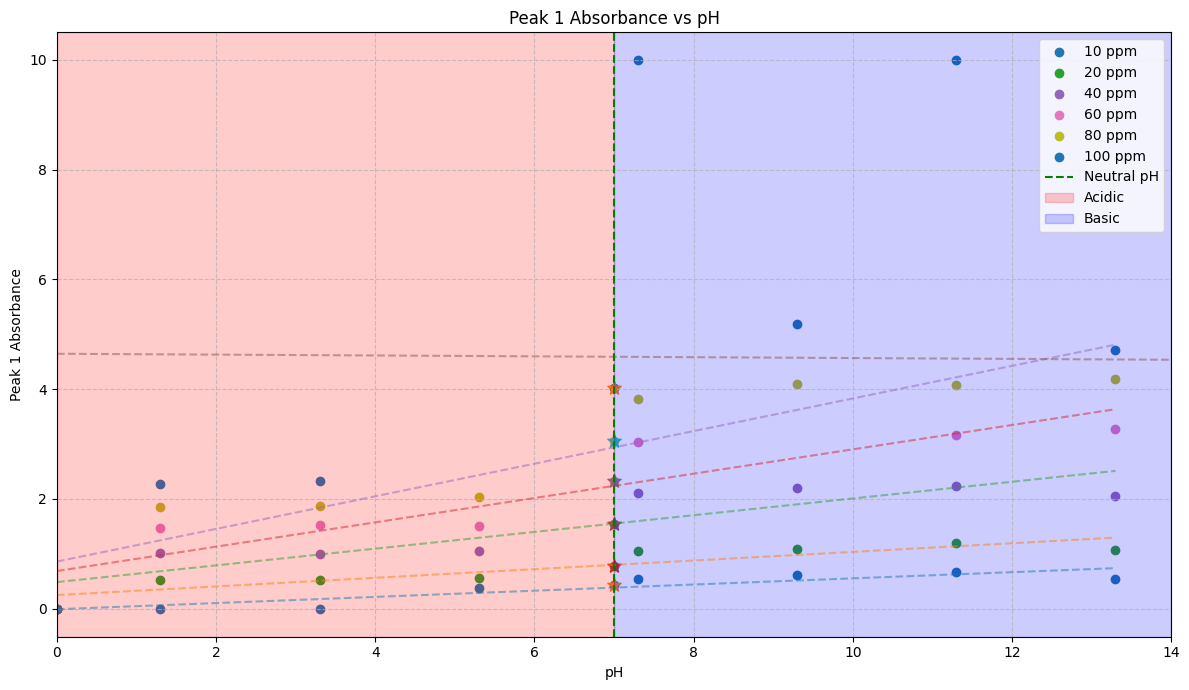

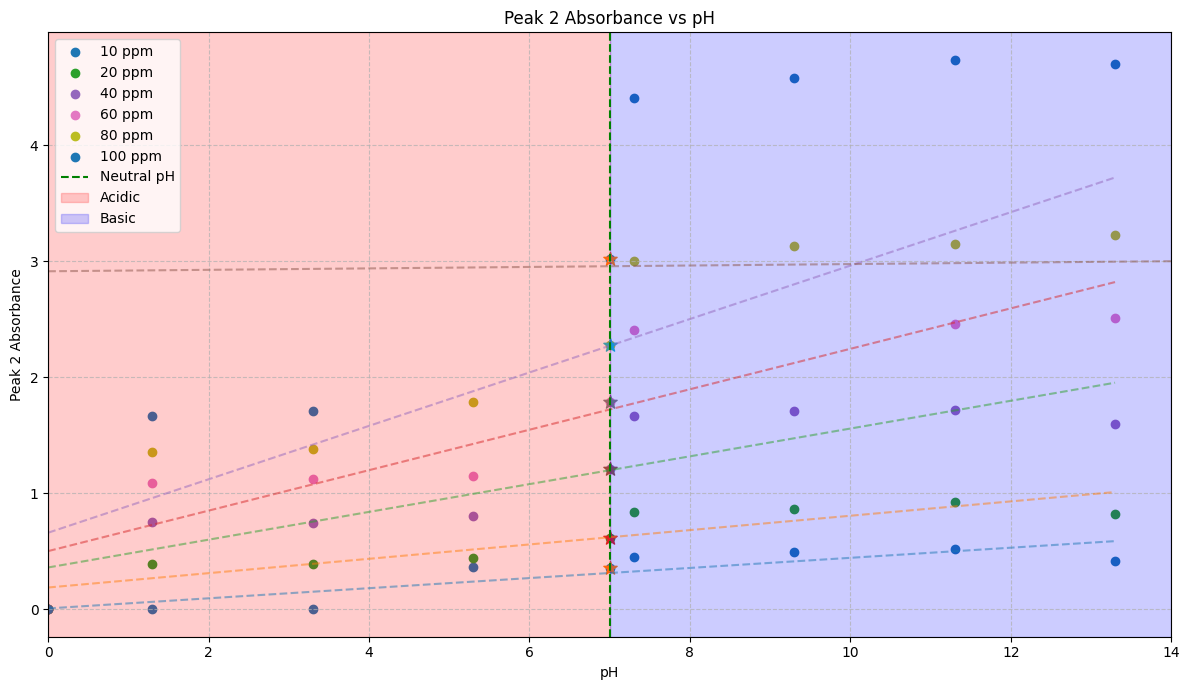

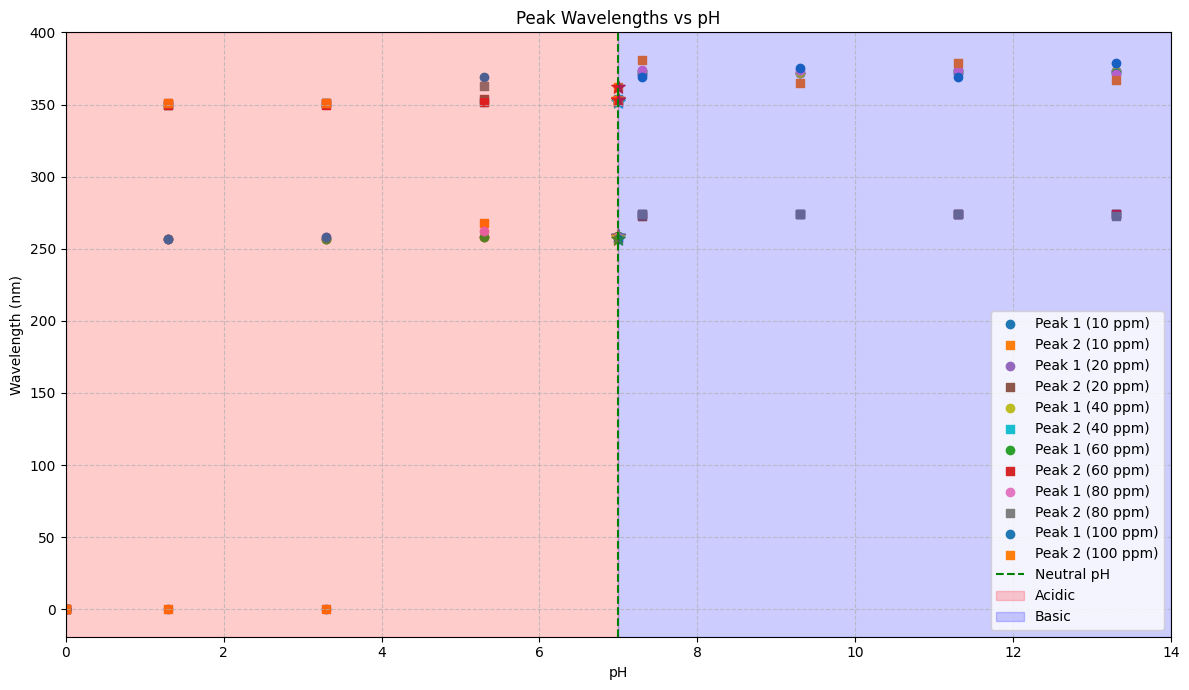


Concentration: 10 ppm
Number of data points: 9
Peak 1 wavelength range: 0.00 - 373.00 nm
Peak 2 wavelength range: 0.00 - 362.00 nm
Correlation coefficient (Peak 1 Absorbance vs pH): 0.9003
Correlation coefficient (Peak 2 Absorbance vs pH): 0.8734

Concentration: 20 ppm
Number of data points: 9
Peak 1 wavelength range: 0.00 - 373.00 nm
Peak 2 wavelength range: 0.00 - 354.00 nm
Correlation coefficient (Peak 1 Absorbance vs pH): 0.9025
Correlation coefficient (Peak 2 Absorbance vs pH): 0.9004

Concentration: 40 ppm
Number of data points: 9
Peak 1 wavelength range: 0.00 - 373.00 nm
Peak 2 wavelength range: 0.00 - 354.00 nm
Correlation coefficient (Peak 1 Absorbance vs pH): 0.8905
Correlation coefficient (Peak 2 Absorbance vs pH): 0.8907

Concentration: 60 ppm
Number of data points: 8
Peak 1 wavelength range: 0.00 - 374.00 nm
Peak 2 wavelength range: 0.00 - 353.00 nm
Correlation coefficient (Peak 1 Absorbance vs pH): 0.9099
Correlation coefficient (Peak 2 Absorbance vs pH): 0.9094

Concent

In [18]:
def plot_linearity_with_ph_regions(data, title, xlabel, ylabel, peak_num):
    plt.figure(figsize=(12, 7))

    for conc in concentrations:
        x = data[conc]['ph']
        y = data[conc][f'peak{peak_num}_abs']
        if len(x) > 0 and len(y) > 0:
            plt.scatter(x, y, label=f'{conc} ppm')

            neutral_index = np.where(x == 7.0)[0]
            if len(neutral_index) > 0:
                plt.scatter(x[neutral_index], y[neutral_index], s=100, marker='*')

            if len(x) > 1:
                slope, intercept, r_value, _, _ = linregress(x, y)
                line = slope * np.array(x) + intercept
                plt.plot(x, line, linestyle='--', alpha=0.5)

    plt.axvline(x=7, color='green', linestyle='--', label='Neutral pH')
    plt.axvspan(0, 7, alpha=0.2, color='red', label='Acidic')
    plt.axvspan(7, 14, alpha=0.2, color='blue', label='Basic')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 14)
    plt.tight_layout()
    plt.show()

plot_linearity_with_ph_regions(all_data, "Peak 1 Absorbance vs pH", "pH", "Peak 1 Absorbance", 1)
plot_linearity_with_ph_regions(all_data, "Peak 2 Absorbance vs pH", "pH", "Peak 2 Absorbance", 2)

plt.figure(figsize=(12, 7))

for conc in concentrations:
    if len(all_data[conc]['ph']) > 0:
        plt.scatter(all_data[conc]['ph'], all_data[conc]['peak1_wl'], label=f'Peak 1 ({conc} ppm)', marker='o')
        plt.scatter(all_data[conc]['ph'], all_data[conc]['peak2_wl'], label=f'Peak 2 ({conc} ppm)', marker='s')

        neutral_index = np.where(all_data[conc]['ph'] == 7.0)[0]
        if len(neutral_index) > 0:
            plt.scatter(all_data[conc]['ph'][neutral_index], all_data[conc]['peak1_wl'][neutral_index], s=100, marker='*')
            plt.scatter(all_data[conc]['ph'][neutral_index], all_data[conc]['peak2_wl'][neutral_index], s=100, marker='*')

plt.axvline(x=7, color='green', linestyle='--', label='Neutral pH')
plt.axvspan(0, 7, alpha=0.2, color='red', label='Acidic')
plt.axvspan(7, 14, alpha=0.2, color='blue', label='Basic')
plt.title("Peak Wavelengths vs pH")
plt.xlabel("pH")
plt.ylabel("Wavelength (nm)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 14)
plt.tight_layout()
plt.show()

for conc in concentrations:
    if len(all_data[conc]['ph']) > 0:
        print(f"\nConcentration: {conc} ppm")
        print(f"Number of data points: {len(all_data[conc]['ph'])}")
        print(f"Peak 1 wavelength range: {np.min(all_data[conc]['peak1_wl']):.2f} - {np.max(all_data[conc]['peak1_wl']):.2f} nm")
        print(f"Peak 2 wavelength range: {np.min(all_data[conc]['peak2_wl']):.2f} - {np.max(all_data[conc]['peak2_wl']):.2f} nm")

        correlation_peak1 = np.corrcoef(all_data[conc]['ph'], all_data[conc]['peak1_abs'])[0, 1]
        correlation_peak2 = np.corrcoef(all_data[conc]['ph'], all_data[conc]['peak2_abs'])[0, 1]
        print(f"Correlation coefficient (Peak 1 Absorbance vs pH): {correlation_peak1:.4f}")
        print(f"Correlation coefficient (Peak 2 Absorbance vs pH): {correlation_peak2:.4f}")
    else:
        print(f"\nNo data available for concentration: {conc} ppm")

## 3. Defining BinaryPHSpectralAnalyzer Class


In [19]:

class BinaryPHSpectralAnalyzer:
    def __init__(self, all_data):
        self.all_data = all_data
        self.concentrations = list(all_data.keys())
        self.ph_model = None
        self.conc_model = None
        self.ph_scaler = StandardScaler()
        self.conc_scaler = StandardScaler()
        self.create_models()

    def create_models(self):
        X_ph, y_ph, X_conc, y_conc = self.prepare_data()

        ph_models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'SVC': SVC(kernel='rbf', probability=True, random_state=42)
        }
        self.ph_model, _ = self.find_best_model(X_ph, y_ph, ph_models, 'pH Classification')

        conc_models = {
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'SVR': SVR(kernel='rbf', C=100, gamma='scale'),
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42),
            'MLP': MLPRegressor(random_state=42),
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=1.0)
        }
        self.conc_model, _ = self.find_best_model(X_conc, y_conc, conc_models, 'Concentration')

    def prepare_data(self):
        X_ph = []
        y_ph = []
        X_conc = []
        y_conc = []
        for conc in self.concentrations:
            X_ph.extend(zip(self.all_data[conc]['peak1_wl'], self.all_data[conc]['peak2_wl'],
                            self.all_data[conc]['peak1_abs'], self.all_data[conc]['peak2_abs']))
            y_ph.extend(self.classify_ph_binary(self.all_data[conc]['ph']))
            X_conc.extend(zip(self.all_data[conc]['ph'], self.all_data[conc]['peak1_abs'], self.all_data[conc]['peak2_abs']))
            y_conc.extend([conc] * len(self.all_data[conc]['ph']))

        X_ph = self.ph_scaler.fit_transform(X_ph)
        X_conc = self.conc_scaler.fit_transform(X_conc)

        return X_ph, y_ph, X_conc, y_conc

    def classify_ph_binary(self, ph_values):
        return ['acidic' if ph < 7 else 'basic' for ph in ph_values]

    def find_best_model(self, X, y, models, model_type):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        best_model = None
        best_score = -np.inf

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if model_type == 'pH Classification':
                score = accuracy_score(y_test, y_pred)
                print(f"{model_type} - {name}:")
                print(f"  Accuracy: {score:.4f}")
                print(classification_report(y_test, y_pred))
            else:
                score = model.score(X_test, y_test)
                print(f"{model_type} - {name}:")
                print(f"  R-squared Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_model = model

        print(f"\nBest {model_type} Model: {type(best_model).__name__}")
        return best_model, best_score

    def predict(self, peak1_wl, peak2_wl, peak1_abs, peak2_abs):
        X_ph = self.ph_scaler.transform([[peak1_wl, peak2_wl, peak1_abs, peak2_abs]])
        ph_class = self.ph_model.predict(X_ph)[0]
        ph_proba = self.ph_model.predict_proba(X_ph)[0]

        if ph_class == 'acidic':
            estimated_ph = 7 * (1 - ph_proba[1])
        else:
            estimated_ph = 7 + 7 * ph_proba[1]

        X_conc = self.conc_scaler.transform([[estimated_ph, peak1_abs, peak2_abs]])
        estimated_conc = self.conc_model.predict(X_conc)[0]

        return ph_class, estimated_ph, estimated_conc

    def evaluate_models(self):
        X_ph, y_ph, X_conc, y_conc = self.prepare_data()

        X_ph_train, X_ph_test, y_ph_train, y_ph_test = train_test_split(X_ph, y_ph, test_size=0.2, random_state=42)
        X_conc_train, X_conc_test, y_conc_train, y_conc_test = train_test_split(X_conc, y_conc, test_size=0.2, random_state=42)

        y_ph_pred = self.ph_model.predict(X_ph_test)
        y_conc_pred = self.conc_model.predict(X_conc_test)

        print("\nFinal Model Evaluation:")
        print("pH Classification Model:")
        print(f"  Accuracy: {accuracy_score(y_ph_test, y_ph_pred):.4f}")
        print(classification_report(y_ph_test, y_ph_pred))
        print("Concentration Prediction Model:")
        print(f"  R-squared Score: {self.conc_model.score(X_conc_test, y_conc_test):.4f}")

        return (y_ph_test, y_ph_pred), (y_conc_test, y_conc_pred)



## 4. Defining Model Performace Plot Function

In [20]:
def plot_model_performance(ph_results, conc_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    cm = confusion_matrix(ph_results[0], ph_results[1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('pH Classification Confusion Matrix')
    ax1.set_xticklabels(['Acidic', 'Basic'])
    ax1.set_yticklabels(['Acidic', 'Basic'])

    ax2.scatter(conc_results[0], conc_results[1], alpha=0.7)
    ax2.plot([min(conc_results[0]), max(conc_results[0])], [min(conc_results[0]), max(conc_results[0])], 'r--', lw=2)
    ax2.set_xlabel('Actual Concentration (ppm)')
    ax2.set_ylabel('Predicted Concentration (ppm)')
    ax2.set_title('Concentration Prediction Performance')
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## 5. Run the Analysis


pH Classification - Random Forest:
  Accuracy: 0.8182
              precision    recall  f1-score   support

      acidic       0.67      0.67      0.67         3
       basic       0.88      0.88      0.88         8

    accuracy                           0.82        11
   macro avg       0.77      0.77      0.77        11
weighted avg       0.82      0.82      0.82        11

pH Classification - Decision Tree:
  Accuracy: 0.8182
              precision    recall  f1-score   support

      acidic       0.67      0.67      0.67         3
       basic       0.88      0.88      0.88         8

    accuracy                           0.82        11
   macro avg       0.77      0.77      0.77        11
weighted avg       0.82      0.82      0.82        11

pH Classification - SVC:
  Accuracy: 0.8182
              precision    recall  f1-score   support

      acidic       0.67      0.67      0.67         3
       basic       0.88      0.88      0.88         8

    accuracy                  

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


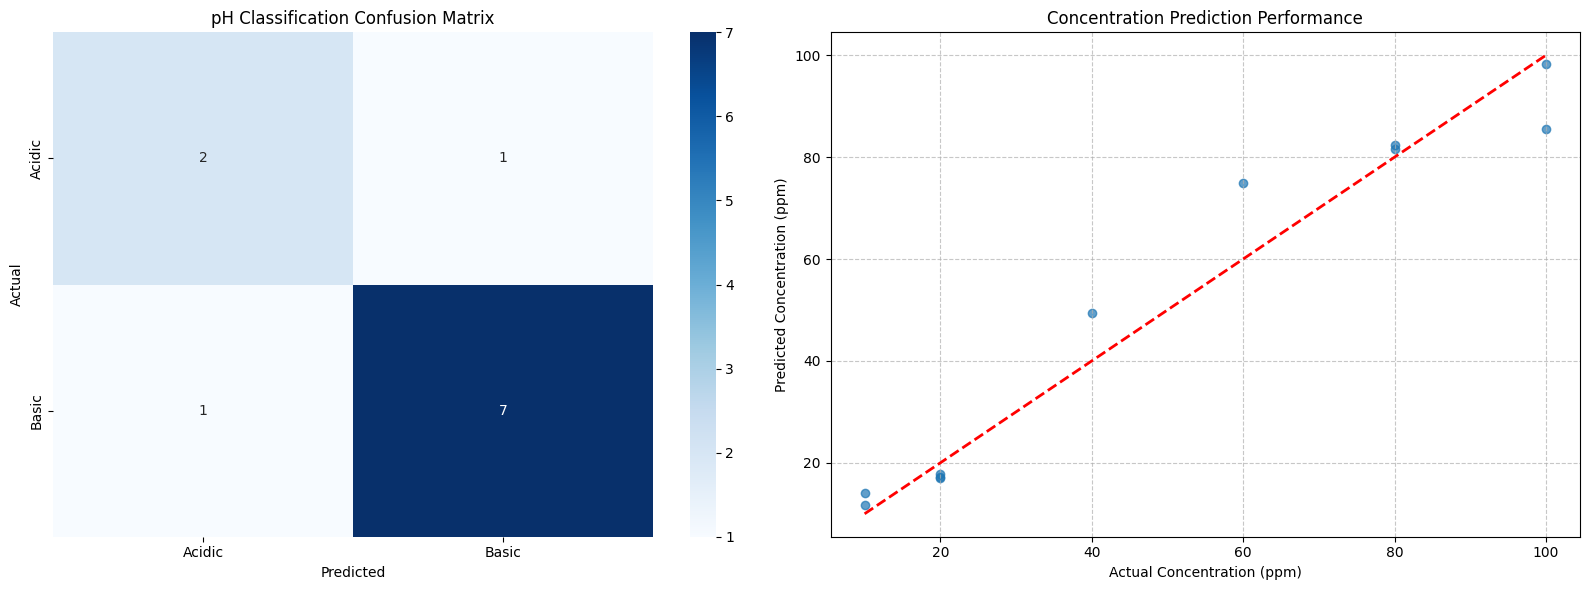

In [21]:
analyzer = BinaryPHSpectralAnalyzer(all_data)

ph_results, conc_results = analyzer.evaluate_models()

plot_model_performance(ph_results, conc_results)